Paper: https://arxiv.org/abs/1602.05629

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.ops import MLP
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim import SGD
import copy
from tqdm import tqdm
from collections import OrderedDict
import random
import matplotlib.pyplot as plt

## Data

In [2]:
K = 100
S = np.array(range(K))

In [23]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x)) # remove for cnn
])

train_dataset = MNIST('datasets/mnist', train=True, download=True, transform=preprocess)
test_dataset = MNIST('datasets/mnist', train=False, download=True, transform=preprocess)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [24]:
iid = True
samples_per_client = int(len(train_dataset) / K)
shards_per_client = 2

def split_data(dataset, iid=True):
    if iid:
        return torch.utils.data.random_split(train_dataset, [samples_per_client] * K)
    else:
        sorted_dataset = sorted(train_dataset, key=lambda x: x[1])
        shard_size = int(samples_per_client / shards_per_client)
        shards = [
            torch.utils.data.Subset(
                sorted_dataset,
                range(i*shard_size, (i+1)*shard_size)
            )
            for i in range(K*shards_per_client)
        ]

        random.shuffle(shards)

        return [
            torch.utils.data.ConcatDataset([shards[2*i], shards[2*i+1]])
            for i in range(K)
        ]


client_datasets = split_data(train_dataset, iid)
assert len(client_datasets) == K
assert len(client_datasets[0]) == samples_per_client
assert iid or all([0 < len(set(map(lambda x: x[1], client_datasets[i]))) <= 4 for i in range(K)])

## Models

In [5]:
model_2nn = MLP(28*28, [200, 200, 10], activation_layer=torch.nn.ReLU).cuda()
model_2nn, sum(p.numel() for p in model_2nn.parameters())

(MLP(
   (0): Linear(in_features=784, out_features=200, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.0, inplace=False)
   (3): Linear(in_features=200, out_features=200, bias=True)
   (4): ReLU()
   (5): Dropout(p=0.0, inplace=False)
   (6): Linear(in_features=200, out_features=10, bias=True)
   (7): Dropout(p=0.0, inplace=False)
 ),
 199210)

In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4* 4 * 64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x).relu())
        x = self.pool(self.conv2(x).relu())

        x = torch.flatten(x, 1)
        x = self.fc1(x).relu()
        x = self.fc2(x)
        x = nn.functional.softmax(x)

        return x


model_cnn = CustomCNN().cuda()
model_cnn, sum(p.numel() for p in model_cnn.parameters())

(CustomCNN(
   (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=1024, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=10, bias=True)
 ),
 582026)

## Training

In [7]:
T = 100
test_freq = 20

In [8]:
criterion = torch.nn.CrossEntropyLoss().cuda()

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy


def client_update(model, k, w, params):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    loader = DataLoader(client_datasets[k], batch_size=params['B'])

    for i in range(params['E']):
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    return model.state_dict()


def train(model, params):
    accuracies = []
    w = model.state_dict()
    for t in tqdm(range(T)):
        m = int(max(params['C']*K, 1))
        s = np.random.choice(S, m, replace=False)

        w_clients = []
        for k in s:
            w_clients.append(client_update(copy.deepcopy(model), k, w, params))

        w = OrderedDict([
            (
                key,
                sum(map(lambda x: x[key], w_clients)) / len(w_clients)
            ) for key in w_clients[0].keys()
        ])

        model.load_state_dict(w)

        if t % test_freq == 0 or t == T-1:
            accuracies.append(test(model))

    return accuracies

params = {'C': 0.2, 'B': 10, 'E': 1}
accuracies_cnn = train(model_cnn, params)

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-20610ae151bd>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)
  1%|          | 1/100 [00:07<13:02,  7.90s/it]

Test Loss: 2.300001 Acc: 29.84%


 21%|██        | 21/100 [01:56<06:11,  4.70s/it]

Test Loss: 1.507220 Acc: 95.64%


 41%|████      | 41/100 [03:31<04:38,  4.72s/it]

Test Loss: 1.488156 Acc: 97.40%


 61%|██████    | 61/100 [04:58<02:59,  4.59s/it]

Test Loss: 1.481780 Acc: 97.97%


 81%|████████  | 81/100 [06:26<01:30,  4.75s/it]

Test Loss: 1.479321 Acc: 98.19%


100%|██████████| 100/100 [07:47<00:00,  4.67s/it]


In [25]:
accuracies_2nn = train(model_2nn, params)

  1%|          | 1/100 [00:04<08:10,  4.96s/it]

Test Loss: 1.560516 Acc: 70.43%


 21%|██        | 21/100 [01:18<05:09,  3.92s/it]

Test Loss: 0.166000 Acc: 95.01%


 41%|████      | 41/100 [02:31<03:49,  3.88s/it]

Test Loss: 0.107993 Acc: 96.68%


 61%|██████    | 61/100 [03:44<02:30,  3.87s/it]

Test Loss: 0.089269 Acc: 97.02%


 81%|████████  | 81/100 [04:57<01:15,  3.99s/it]

Test Loss: 0.076859 Acc: 97.51%


100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


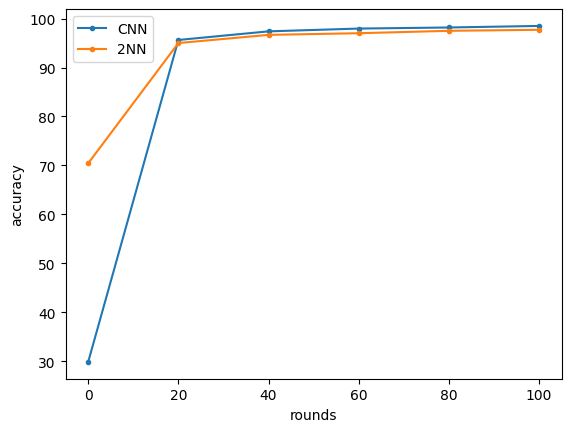

In [37]:
plt.xlabel('rounds')
plt.ylabel('accuracy')
xx = np.arange(0, T + test_freq, test_freq)
plt.plot(xx, accuracies_cnn, label='CNN', marker='.')
plt.plot(xx, accuracies_2nn, label='2NN', marker='.')
plt.legend()

In [ ]:
BB = [10, len(client_datasets[0])]
EE = [1, 5]

acc_dict = {}
for B in BB:
    for E in EE:
        print(B, E)
        params = {'C': 0.2, 'B': B, 'E': E}
        acc_dict[f'B={B},E={E}'] = train(model_cnn, params)